* Import Statements

In [1]:
#!pip install quilt

In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from citipy import citipy

# Dataset Cleanup

* DataType Cleanups.  Import the file.   Change the column data types.

In [3]:
#Import the raw file
ufo_df = pd.read_csv("Data/scrubbed.csv")

#Convert the datetime to a datetime.  Drop any bad rows.
ufo_df['datetime']= pd.to_datetime(ufo_df['datetime'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['datetime'])

#Convert the date posted to a datetime.  Drop any bad rows.
ufo_df['date posted']= pd.to_datetime(ufo_df['date posted'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['date posted'])

#Convert the duration (seconds) posted to a float.  Drop any bad rows.
ufo_df['duration (seconds)']= pd.to_numeric(ufo_df['duration (seconds)'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['duration (seconds)'])

#Convert the latitude posted to a number.  Drop any bad rows.
ufo_df['latitude']= pd.to_numeric(ufo_df['latitude'], errors='coerce')
ufo_df = ufo_df.dropna(subset=['latitude'])

#Fix the name.  Drop any bad rows.
ufo_df.rename(inplace=True,columns={'longitude ':'longitude', 'duration (seconds)':'duration' })
ufo_df = ufo_df.dropna(subset=['longitude'])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


* Cleanup the column values for city and country.  Use citipy, with the latitude and longitude.  By the way these columns looked like they were swapped ('latitude' is 'longitude', and vice-versa).

In [4]:
for i,row in ufo_df.iterrows():
    ufo_df.at[i,'city'] = citipy.nearest_city(row['latitude'],row['longitude']).city_name.strip()
    ufo_df.at[i,'country'] = citipy.nearest_city(row['latitude'],row['longitude']).country_code.strip()

* Drop uneeded columns.

In [5]:
del ufo_df['duration (hours/min)']
del ufo_df['comments']


* Split out the datetime into seperate columns so its easier to work with.

In [7]:
datetime.datetime.today().weekday()

3

In [9]:
ufo_df['year'] = ufo_df['datetime'].dt.year
ufo_df['month'] = ufo_df['datetime'].dt.month
ufo_df['day'] = ufo_df['datetime'].dt.day
ufo_df['hour'] = ufo_df['datetime'].dt.hour
ufo_df['minute'] = ufo_df['datetime'].dt.minute
ufo_df['day_name'] = ufo_df['datetime'].dt.day_name()
ufo_df.head()

,datetime,city,state,country,shape,duration,date posted,latitude,longitude,year,month,day,hour,minute,day_name
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,2004-04-27,29.883056,-97.941111,1949,10,10,20,30,Monday
1,1949-10-10 21:00:00,san antonio,tx,us,light,7200.0,2005-12-16,29.384210,-98.581082,1949,10,10,21,0,Monday
2,1955-10-10 17:00:00,chester,NaN,gb,circle,20.0,2008-01-21,53.200000,-2.916667,1955,10,10,17,0,Monday
3,1956-10-10 21:00:00,port lavaca,tx,us,circle,20.0,2004-01-17,28.978333,-96.645833,1956,10,10,21,0,Wednesday
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,2004-01-22,21.418056,-157.803611,1960,10,10,20,0,Monday


# Observations and Data Visualizations

## Which are the top 10 countries do ufo sightings occur the most?

In [32]:
#Create a dataframe from a group by.  
most_ufo_by_country_df = pd.DataFrame(ufo_df.groupby(['country'])['datetime'].count())
most_ufo_by_country_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_country_df['percentage'] = most_ufo_by_country_df['counts']/most_ufo_by_country_df['counts'].sum()*100
most_ufo_by_country_df['percentage'] = most_ufo_by_country_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_country_df = most_ufo_by_country_df.reset_index()

most_ufo_by_country_df1 = most_ufo_by_country_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_country_df1.sort_values(by='counts', ascending=False)
most_ufo_by_country_df1.to_excel('Top10Countries.xls', index=False)

## Visualize the sightings by top 10 countries across the last 25 years.

In [11]:
# Create a dataframe from a group by country and year. 
most_ufo_by_country_year_df = pd.DataFrame(ufo_df.groupby(['country','year'])['datetime'].count())

# Fix the name of the count column.
most_ufo_by_country_year_df.rename(inplace=True,columns={'datetime':'counts'})

# Pull the 'country','year' out of the index so we can use the unique on it below.
most_ufo_by_country_year_df = most_ufo_by_country_year_df.reset_index()
 

#most_ufo_by_country_year_df.head()

 

# Pull out just the top 10 countries we need.
most_ufo_by_country_year_df1 = pd.merge(most_ufo_by_country_year_df, most_ufo_by_country_df1, how="inner", on="country")


#Fix the count name due to the merge
most_ufo_by_country_year_df1 = most_ufo_by_country_year_df1.rename(columns={'counts_x':'counts'})

# Drop the count column from the top 10 countries.
del most_ufo_by_country_year_df1['counts_y']


# This one was a serious pain in the ass so its worth explaining.
# We are creating columns for every country and years for the rows.
# We have to create an index with every possible year, beacuse if we don't the first country to hit loop will
# set the index.  I spent hours trying to figure this out.
most_ufo_by_country_year_df2 = pd.DataFrame(index=pd.Index(most_ufo_by_country_year_df['year'].unique()).sort_values())

 

# Rename the index so its clear.
most_ufo_by_country_year_df2.index.names=['year']

#Put the index back so it can be used in the loop.
most_ufo_by_country_year_df1 = most_ufo_by_country_year_df1.set_index(['year'])
for country in most_ufo_by_country_year_df1['country'].unique():
    most_ufo_by_country_year_df2[country] = most_ufo_by_country_year_df1[most_ufo_by_country_year_df1['country'] == country]['counts']

 
most_ufo_by_country_year_df2 = most_ufo_by_country_year_df2.reset_index()
most_ufo_by_country_year_df2 = most_ufo_by_country_year_df2.fillna(0)
most_ufo_by_country_year_df3 = most_ufo_by_country_year_df2.sort_values(by='year', ascending=False).head(50)
most_ufo_by_country_year_df3.head()

,year,au,br,ca,de,gb,in,mx,nl,nz,us
86,2014,13.0,2.0,62.0,3.0,25.0,13.0,3.0,1.0,1.0,2093.0
85,2013,38.0,2.0,314.0,5.0,61.0,22.0,15.0,1.0,5.0,6440.0
84,2012,23.0,3.0,309.0,7.0,99.0,25.0,9.0,3.0,5.0,6697.0
83,2011,15.0,5.0,170.0,4.0,57.0,4.0,13.0,2.0,0.0,4702.0
82,2010,18.0,2.0,167.0,4.0,134.0,5.0,8.0,8.0,6.0,3811.0


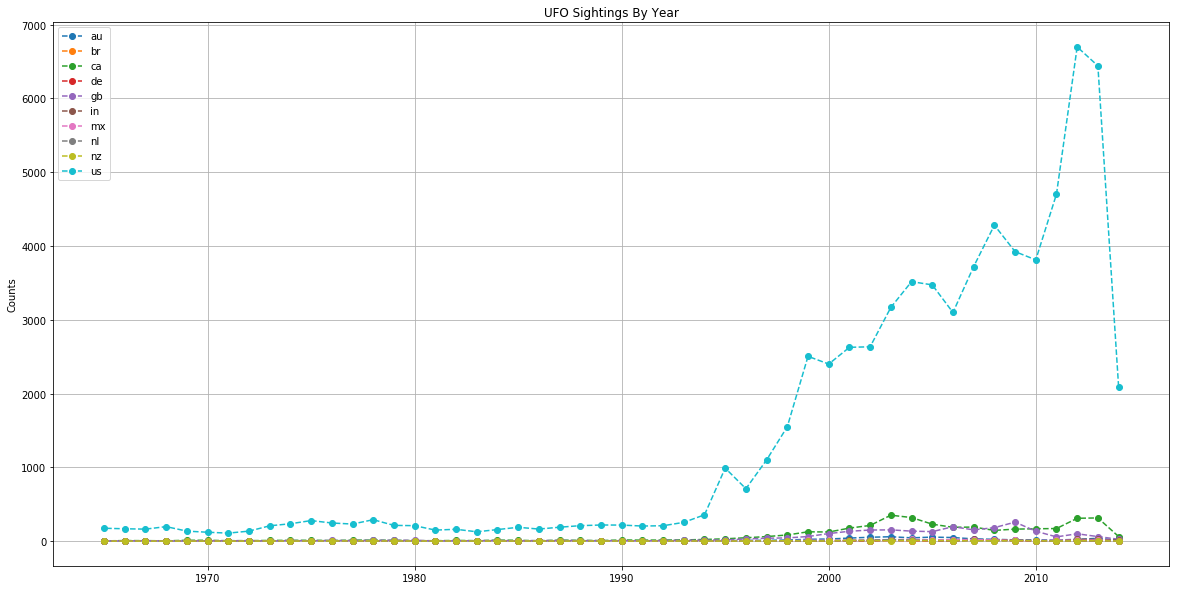

In [31]:
fig, axes = plt.subplots(1,1,sharex=True, sharey=True, figsize=(20,10))

#Turn on the grid
axes.grid()
for column in most_ufo_by_country_year_df3:
    if column != 'year':
        axes.errorbar(x=most_ufo_by_country_year_df3['year'], y=most_ufo_by_country_year_df3[column], \
                     label=column, \
                     linestyle='dashed', marker='o'
                     )

# Plot title
plt.title('UFO Sightings By Year')
axes.set_ylabel('Counts')
# Create a legend
plt.legend(loc='upper left' )
plt.savefig("year.png")
plt.show()

## Which cities have the most ufo sightings?

In [34]:
most_ufo_by_city_df = pd.DataFrame(ufo_df.groupby(['city','state','country', 'longitude','latitude'])['datetime'].count())
most_ufo_by_city_df.rename(inplace=True,columns={'datetime':'counts'})
most_ufo_by_city_df['percentage'] = most_ufo_by_city_df['counts']/most_ufo_by_city_df['counts'].sum()*100
most_ufo_by_city_df['percentage'] = most_ufo_by_city_df['percentage'].map('{:,.2f}%'.format)
most_ufo_by_city_df = most_ufo_by_city_df.reset_index()
most_ufo_by_city_df = most_ufo_by_city_df.sort_values(by='counts', ascending=False).head(15)

most_ufo_by_city_df.to_excel('Top15Cities.xls', index=False)


## Visualization of ufo sightings across the world.  Seems rather odd the US has 90% of them

In [14]:
# This was a pain to install
import geopandas
from shapely.geometry import Point

most_ufo_by_city_df['Coordinates'] = list(zip(most_ufo_by_city_df['longitude'], most_ufo_by_city_df['latitude']))
most_ufo_by_city_df['Coordinates'] = most_ufo_by_city_df['Coordinates'].apply(Point)

gdf = geopandas.GeoDataFrame(most_ufo_by_city_df, geometry='Coordinates')

gdf.head()

,city,state,country,longitude,latitude,counts,percentage,Coordinates
0,abbeville,la,us,-92.381362,29.860141,1,0.00%,POINT (-92.381362 29.860141)
1,abbeville,la,us,-92.300000,29.831111,1,0.00%,POINT (-92.3 29.8311111)
2,abbeville,la,us,-92.134167,29.974444,4,0.01%,POINT (-92.13416670000001 29.9744444)
3,abbeville,la,us,-92.035833,29.958056,1,0.00%,POINT (-92.03583329999999 29.95805560000001)
4,abbotsford,bc,ca,-122.300000,49.133333,3,0.00%,POINT (-122.3 49.133333)


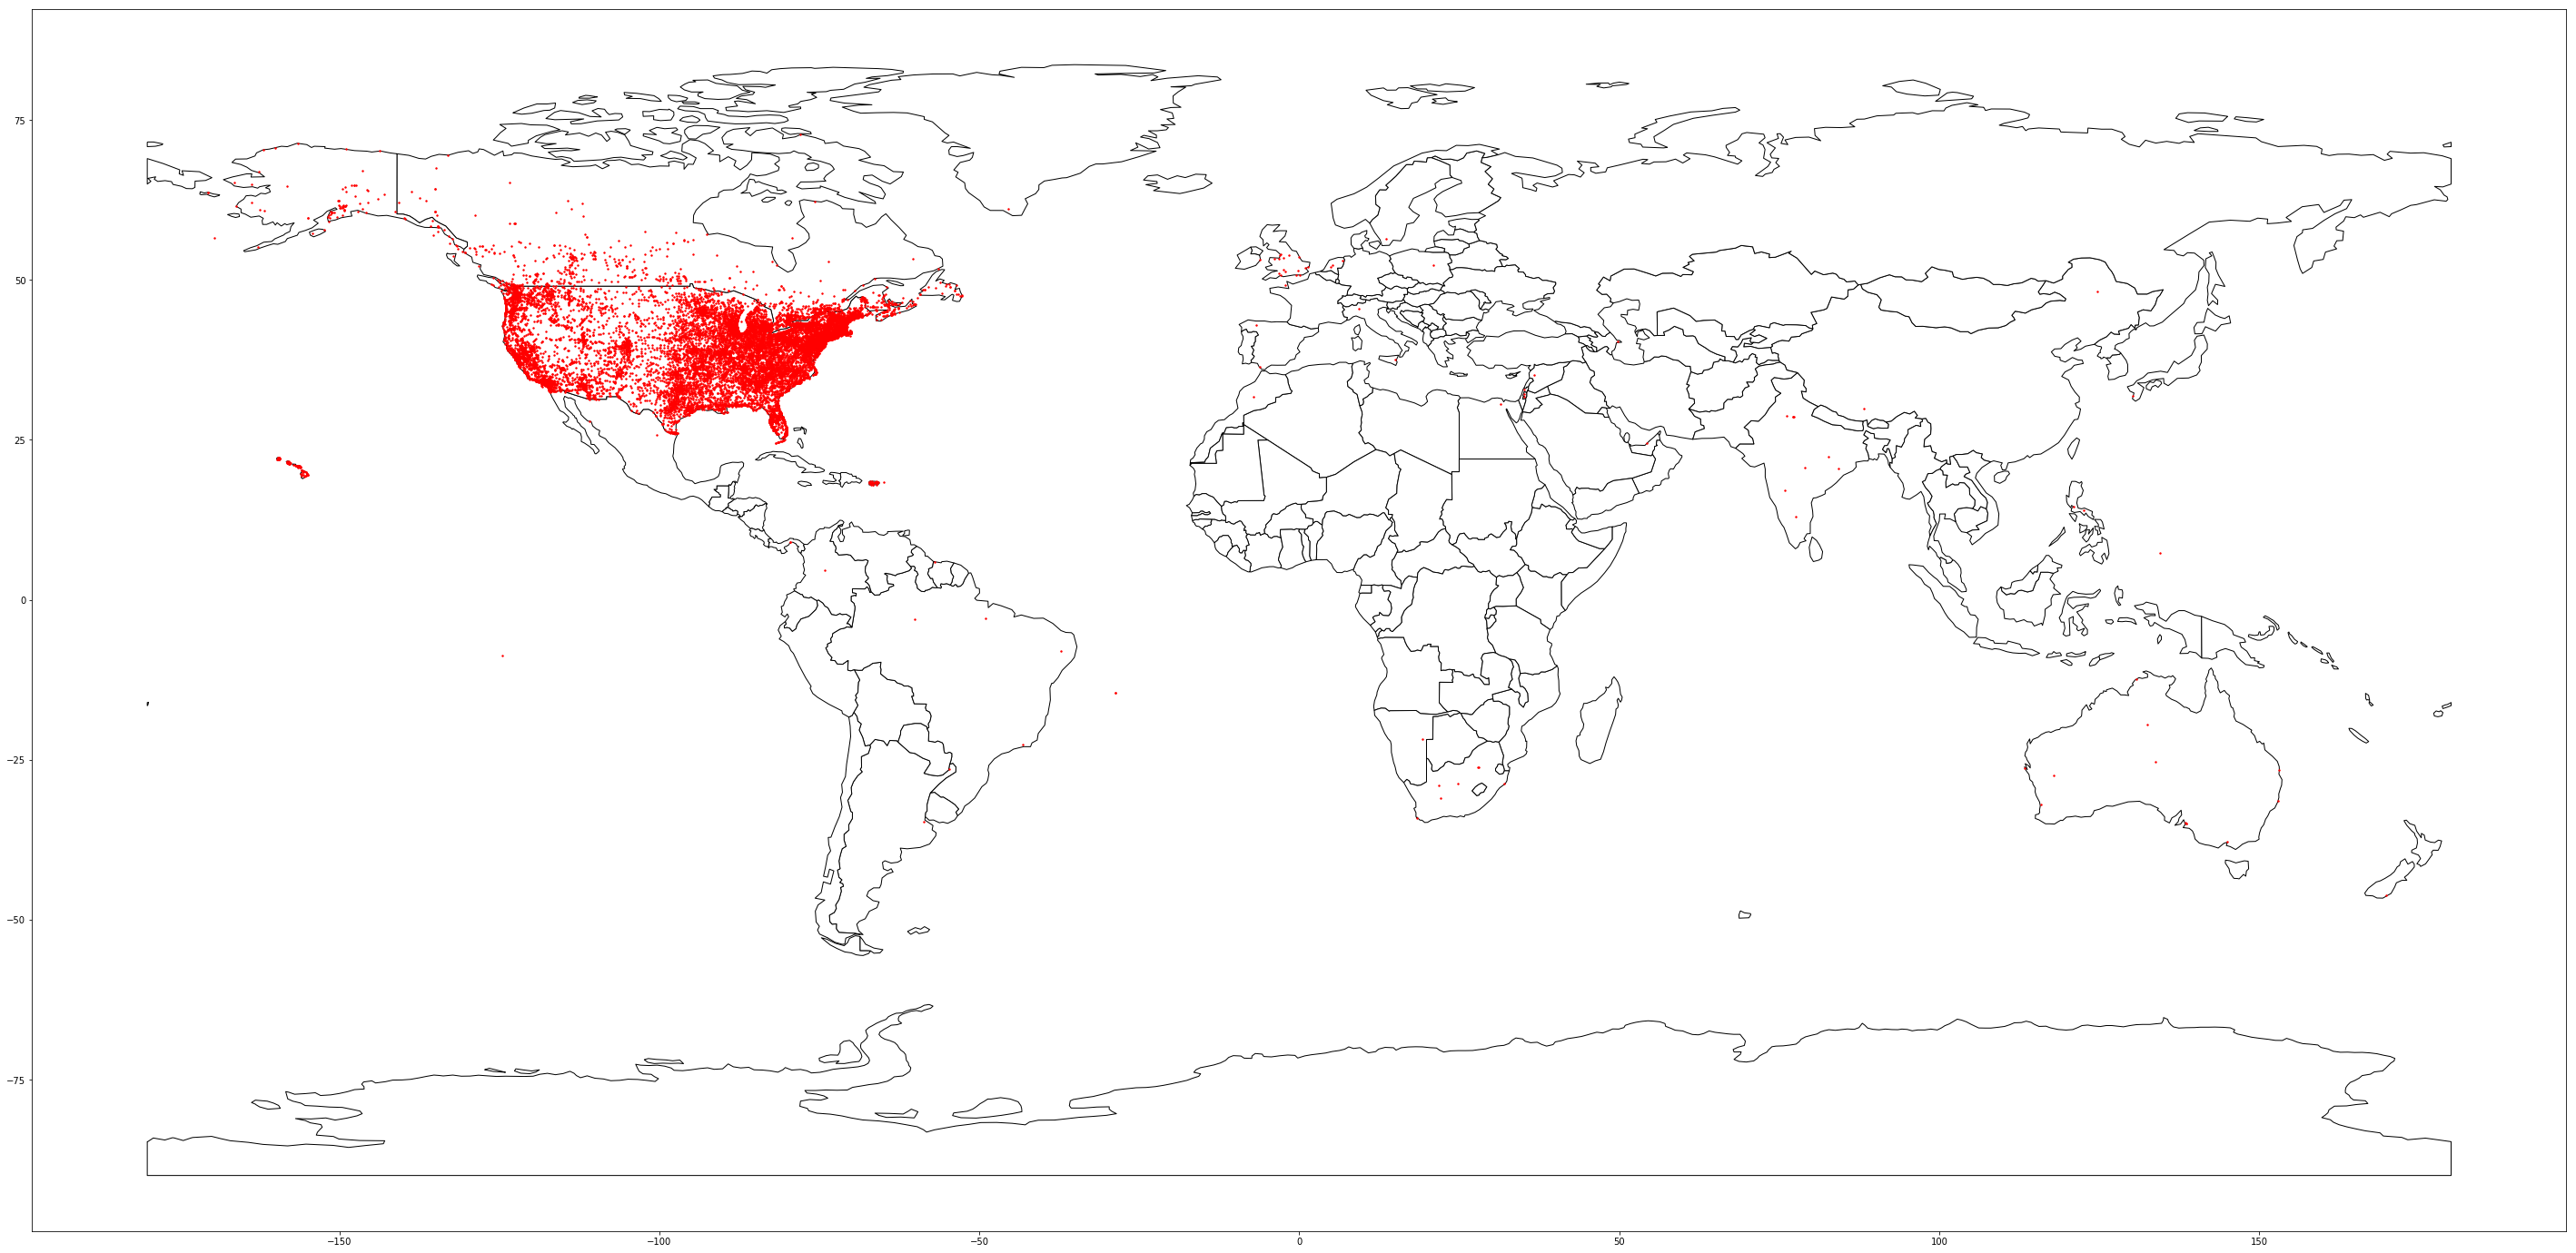

In [30]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(50,50))
gdf.plot(ax=ax, marker='o', color='red', markersize=2)
plt.savefig("world.png")
plt.show()

# More ideas
* Are ufo sitings increasing or decreasing.
   Visualization: A bar chart showing year as the x axis, and the siting counts as the y axis.

* Do you see more lights at night?
    Visualization: Shapes versus Time of day.  Bar chart x is shape, time of day is y.
* What is the best place to see a ufo?
    Visualization: The top 10 places to see a UFO over the last 5 years.  Table or barchart

For each of the top 10 places:

* What month should you go?
* What time should you look outside?
* What shape should you look for?

# Which hours have the most sighting?

In [16]:
#Create a dataframe from a group by.  
most_ufo_by_hour_df = pd.DataFrame(ufo_df.groupby(['hour'])['datetime'].count())
most_ufo_by_hour_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_hour_df['percentage'] = most_ufo_by_hour_df['counts']/most_ufo_by_hour_df['counts'].sum()*100
most_ufo_by_hour_df['percentage'] = most_ufo_by_hour_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_hour_df = most_ufo_by_hour_df.reset_index()

most_ufo_by_hour_df10 = most_ufo_by_hour_df.sort_values(by='hour')

most_ufo_by_hour_df10

,hour,counts,percentage
0,0,4108,5.16%
1,1,3210,4.03%
2,2,2357,2.96%
3,3,2004,2.52%
4,4,1529,1.92%
5,5,1590,2.00%
6,6,1224,1.54%
7,7,905,1.14%
8,8,803,1.01%
9,9,958,1.20%


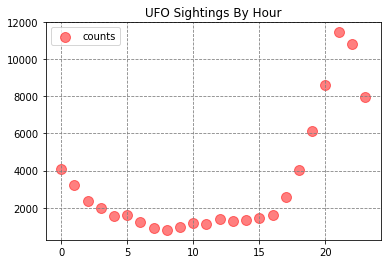

In [29]:
axes = plt.scatter(most_ufo_by_hour_df10['hour'],most_ufo_by_hour_df10['counts'], c='r', s=100, alpha=0.5)

# Plot title
plt.title('UFO Sightings By Hour')

# Create a legend
plt.legend(loc='upper left' )
plt.grid(color='gray', linestyle='--')
plt.savefig("hour.png")
plt.show()

In [18]:
#Create a dataframe from a group by.  
most_ufo_by_day_df = pd.DataFrame(ufo_df.groupby(['day'])['datetime'].count())
most_ufo_by_day_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_day_df['percentage'] = most_ufo_by_day_df['counts']/most_ufo_by_day_df['counts'].sum()*100
most_ufo_by_day_df['percentage'] = most_ufo_by_day_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_day_df = most_ufo_by_day_df.reset_index()

most_ufo_by_day_df11 = most_ufo_by_day_df.sort_values(by='day')

most_ufo_by_day_df11

,day,counts,percentage
0,1,5508,6.92%
1,2,2176,2.73%
2,3,2344,2.94%
3,4,3100,3.89%
4,5,2474,3.11%
5,6,2309,2.90%
6,7,2381,2.99%
7,8,2283,2.87%
8,9,2168,2.72%
9,10,2881,3.62%


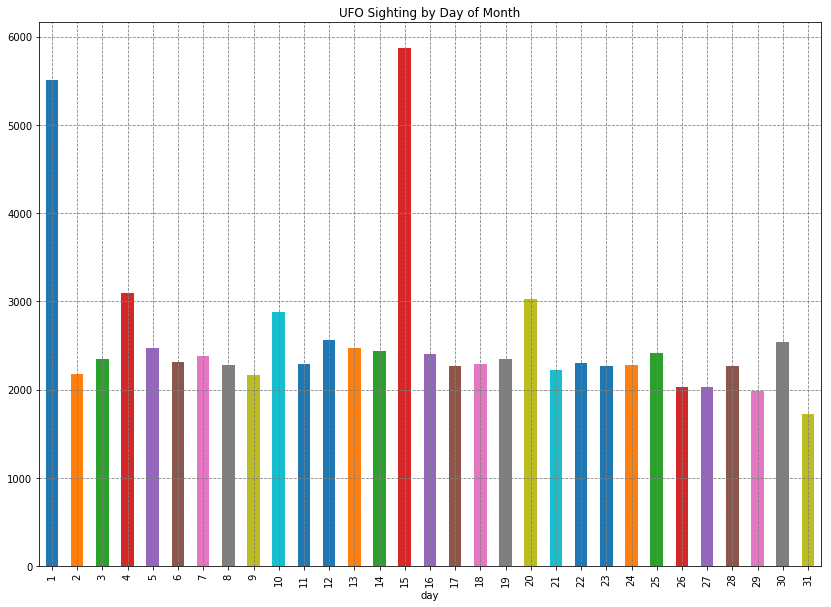

In [28]:
lines = most_ufo_by_day_df11.plot.bar(x='day',y='counts', width=0.5, figsize=(14,10), legend=None)

#Plot Title
plt.title('UFO Sighting by Day of Month')

#Create Legengs
#plt.legend(loc='upper left')
plt.grid(color='gray', linestyle='--')

plt.savefig("monthday.png")
plt.show()


# Sightings by month

* July has the most sightings on any month.
* The summer months have more sightings than any of the other months. I'm asumsing this is because people tend to be outside more during this time of the year. Furthermore, the skies tend to be clearly and there is less adverse weather and cloud coverage during the summer months. 
*

In [27]:
most_ufo_by_month_df = pd.DataFrame(ufo_df.groupby(['month'])['datetime'].count())
most_ufo_by_month_df.rename(inplace=True,columns={'datetime':'counts'})
most_ufo_by_month_df.sort_values(by='month', ascending=True).head(15)

,counts
month,
1,5632
2,4625
3,5408
4,5491
5,5239
6,8019
7,9440
8,8588
9,7535


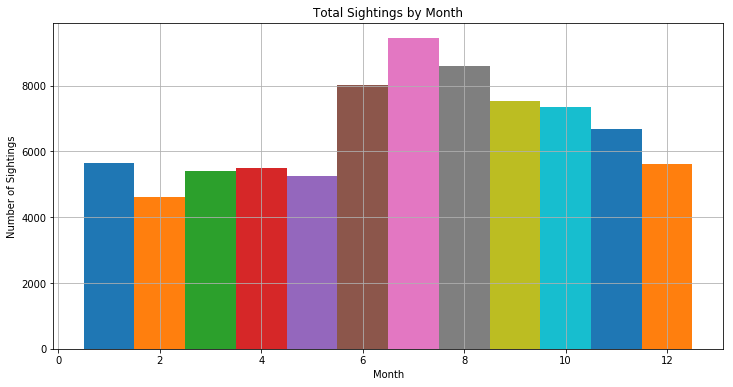

In [26]:
fig = plt.figure(figsize=(12, 6)); 
axes = fig.add_subplot(1, 1, 1)

#Turn on the grid
axes.grid()
for index, cell in most_ufo_by_month_df.iterrows():
    axes.bar(x=index, y=0, height=cell['counts'], \
                 width=1
            )

rects = axes.patches


# Plot title
plt.title('Total Sightings by Month')
axes.set_ylabel("Number of Sightings");
axes.set_xlabel("Month");

plt.savefig("month.png")
plt.show()

In [22]:
#Create a dataframe from a group by.  
most_ufo_by_shape_df = pd.DataFrame(ufo_df.groupby(['shape'])['datetime'].count())
most_ufo_by_shape_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['counts']/most_ufo_by_shape_df['counts'].sum()*100
#most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_shape_df = most_ufo_by_shape_df.reset_index()

most_ufo_by_shape_df1 = most_ufo_by_shape_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_shape_df1.sort_values(by='counts', ascending=False)

,shape,counts,percentage
18,light,16465,21.178211
26,triangle,7813,10.049521
4,circle,7532,9.688083
13,fireball,6166,7.931057
19,other,5591,7.191459
27,unknown,5532,7.115570
24,sphere,5341,6.869895
11,disk,5138,6.608785
20,oval,3699,4.757862
16,formation,2442,3.141038


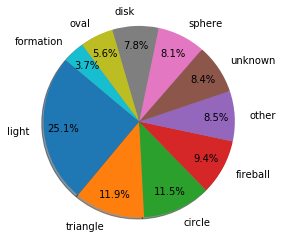

In [25]:
# Build Pie Chart
#Add the figure
fig, axes = plt.subplots(1,1,sharex=True, sharey=True)
#explode = (.1, 0, .1) 
colors=['gold','lightblue','red']
axes.pie(most_ufo_by_shape_df1['percentage'], \
         labels=most_ufo_by_shape_df1['shape'], \
         #explode=explode, colors=colors, \
         autopct='%1.1f%%', shadow=True, startangle=140, \
         radius = 1.1, labeldistance = 1.15, pctdistance=.8
        )

plt.savefig("shapes.png")
plt.show()

In [15]:
#Create a dataframe from a group by.  
most_ufo_by_day_df = pd.DataFrame(ufo_df.groupby(['day_name'])['datetime'].count())
most_ufo_by_day_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_day_df['percentage'] = most_ufo_by_day_df['counts']/most_ufo_by_day_df['counts'].sum()*100
#most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_day_df = most_ufo_by_day_df.reset_index()

most_ufo_by_day_df1 = most_ufo_by_day_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_day_df1.sort_values(by='counts', ascending=False)

,day_name,counts,percentage
2,Saturday,13964,17.535224
3,Sunday,11688,14.677148
0,Friday,11507,14.449858
4,Thursday,10918,13.710224
6,Wednesday,10872,13.652460
5,Tuesday,10699,13.435216
1,Monday,9986,12.539870


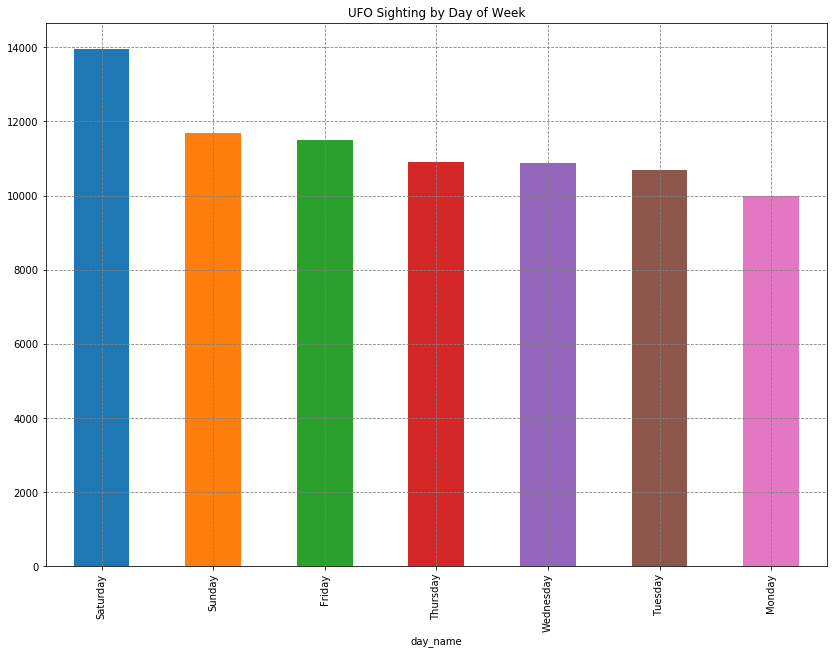

In [16]:
lines = most_ufo_by_day_df1.plot.bar(x='day_name',y='counts', width=0.5, figsize=(14,10), legend=None)

#Plot Title
plt.title('UFO Sighting by Day of Week')

#Create Legengs
#plt.legend(loc='upper left')
plt.grid(color='gray', linestyle='--')

plt.savefig("day_of_week.png")
plt.show()


In [18]:
#Create a dataframe from a group by.  
most_ufo_by_day_hour_df = pd.DataFrame(ufo_df.groupby(['day_name','hour'])['datetime'].count())
most_ufo_by_day_hour_df.rename(inplace=True,columns={'datetime':'counts'})

most_ufo_by_day_hour_df['percentage'] = most_ufo_by_day_hour_df['counts']/most_ufo_by_day_hour_df['counts'].sum()*100
#most_ufo_by_shape_df['percentage'] = most_ufo_by_shape_df['percentage'].map('{:,.2f}%'.format)

most_ufo_by_day_hour_df = most_ufo_by_day_hour_df.reset_index()

most_ufo_by_day_hour_df1 = most_ufo_by_day_hour_df.sort_values(by='counts', ascending=False).head(10)

most_ufo_by_day_hour_df1.to_excel('datesandtimes.xls', index=False)